In [133]:
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, scale

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [135]:
 df = pd.read_csv("train_all_tasks.csv")

In [136]:
df.head()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [137]:
df.drop('rewire_id', axis=1, inplace=True)
df.head()

,text,label_sexist,label_category,label_vector
0,"Damn, this writing was pretty chaotic",not sexist,none,none
1,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,Understand. Know you're right. At same time I ...,not sexist,none,none
4,Surprized they didn't stop and rape some women,not sexist,none,none


**bold text**#### DATA CLEANING

In [138]:
def clean_text(text):
    # Remove any non-alphanumeric characters except whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [139]:
# Define stop words
stop_words = set(stopwords.words('english'))

# Initialize WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

def remove_stopwords(text):
    """
    Function to remove stop words from text.

    Parameters:
        text (str): Input text.

    Returns:
        str: Text with stop words removed.
    """
    # Tokenize the text
    words = text.split()
    # Remove stop words
    filtered_words = [word for word in words if word not in stop_words]
    # Join the filtered words back into a string
    filtered_text = ' '.join(filtered_words)
    return filtered_text

def lemmatize_text(text):
    """
    Function to lemmatize words in text.

    Parameters:
        text (str): Input text.

    Returns:
        str: Text with lemmatized words.
    """
    # Tokenize the text
    words = text.split()
    # Lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # Join the lemmatized words back into a string
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

In [140]:
# Apply cleaning function
df['text'] = df['text'].apply(clean_text)

# Remove stop words
df['text'] = df['text'].apply(remove_stopwords)

# Lemmatize words
df['text'] = df['text'].apply(lemmatize_text)


In [141]:
df.head()

,text,label_sexist,label_category,label_vector
0,damn writing pretty chaotic,not sexist,none,none
1,yeah apparently bunch misogynistic virgin one ...,not sexist,none,none
2,fuck woman still mp,not sexist,none,none
3,understand know youre right time know isnt eno...,not sexist,none,none
4,surprized didnt stop rape woman,not sexist,none,none


## TASK A

In [142]:
df_A = df[['text', 'label_sexist']]
df_A.head()

,text,label_sexist
0,damn writing pretty chaotic,not sexist
1,yeah apparently bunch misogynistic virgin one ...,not sexist
2,fuck woman still mp,not sexist
3,understand know youre right time know isnt eno...,not sexist
4,surprized didnt stop rape woman,not sexist


In [143]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the class labels
df_A['encoded_labels'] = label_encoder.fit_transform(df_A['label_sexist'])
df_A.head()

,text,label_sexist,encoded_labels
0,damn writing pretty chaotic,not sexist,0
1,yeah apparently bunch misogynistic virgin one ...,not sexist,0
2,fuck woman still mp,not sexist,0
3,understand know youre right time know isnt eno...,not sexist,0
4,surprized didnt stop rape woman,not sexist,0


In [144]:
df_A.drop('label_sexist', axis=1, inplace=True)
df_A.head()

,text,encoded_labels
0,damn writing pretty chaotic,0
1,yeah apparently bunch misogynistic virgin one ...,0
2,fuck woman still mp,0
3,understand know youre right time know isnt eno...,0
4,surprized didnt stop rape woman,0


In [145]:
type(df_A['encoded_labels'])

pandas.core.series.Series

In [146]:
type(df_A['encoded_labels'].values)

numpy.ndarray

In [147]:
# Tokenize the 'text' column
df_A['tokenized_text'] = df_A['text'].apply(word_tokenize)
df_A.head()

,text,encoded_labels,tokenized_text
0,damn writing pretty chaotic,0,"[damn, writing, pretty, chaotic]"
1,yeah apparently bunch misogynistic virgin one ...,0,"[yeah, apparently, bunch, misogynistic, virgin..."
2,fuck woman still mp,0,"[fuck, woman, still, mp]"
3,understand know youre right time know isnt eno...,0,"[understand, know, youre, right, time, know, i..."
4,surprized didnt stop rape woman,0,"[surprized, didnt, stop, rape, woman]"


In [148]:
df_A.shape

(14000, 3)

#### WORD2VEC

In [149]:
#WORD2VEC()
cores = multiprocessing.cpu_count() # Count the number of cores in a computer, important for a parameter of the model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

#BUILD_VOCAB()
t = time()
w2v_model.build_vocab(df_A["tokenized_text"], progress_per=1000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

#TRAIN()
w2v_model.train(df_A["tokenized_text"], total_examples=w2v_model.corpus_count, epochs=1000, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to build vocab: 0.0 mins
Time to train the model: 4.73 mins


#### DATA SPLIT

In [150]:
#First defining the X (input), and the y (output)
y = df_A['encoded_labels'].values
X = np.array(df_A["tokenized_text"])

#And here is the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [151]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10500,), (3500,), (10500,), (3500,))

#### VECTORIZATION USING TFIDF

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with custom analyzer
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)

# Fit and transform the data to obtain the TF-IDF matrix
matrix = vectorizer.fit_transform(X_train)

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate IDF values manually
idf_values = vectorizer.idf_

# Create a dictionary mapping feature names to IDF values
tfidf = dict(zip(feature_names, idf_values))

print('Vocabulary size:', len(tfidf))


Vocabulary size: 1987


In [153]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [154]:
train_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_test)])
test_vecs_w2v = scale(test_vecs_w2v)

print ('shape for training set : ',train_vecs_w2v.shape,
      '\nshape for test set : ', test_vecs_w2v.shape)

shape for training set :  (10500, 300) 
shape for test set :  (3500, 300)


In [155]:
train_vecs_w2v, test_vecs_w2v,y_train,  y_test

(array([[ 0.77026027, -0.66688813, -1.32145109, ...,  0.56505612,
          0.03784384, -0.95058832],
        [ 0.41225777,  0.7667027 , -0.5540988 , ..., -0.5649041 ,
         -0.27238994,  0.68031903],
        [ 0.22542721,  0.09492752, -1.49226812, ...,  0.33405811,
          0.94177993, -0.95364494],
        ...,
        [-0.26897174, -0.29434488,  0.2841825 , ..., -0.62978248,
         -0.68106046,  0.23093173],
        [-0.1496969 ,  0.27565479, -0.02725077, ...,  0.2425806 ,
         -0.79596118, -0.89418676],
        [ 0.23822014,  0.35056648,  0.3803916 , ..., -0.04377073,
          0.2896169 , -0.67362131]]),
 array([[-0.46139872,  0.27429537, -0.70938418, ..., -0.78719243,
         -0.18931135,  0.24881493],
        [ 1.0915505 ,  0.77614903,  0.1716384 , ..., -0.00647732,
          0.6861616 , -0.21879231],
        [ 0.31139696,  1.41424196, -1.52551784, ..., -0.63306115,
         -0.6569433 , -2.054435  ],
        ...,
        [-0.63199227,  1.00763411,  1.09633252, ...,  

#### BUILDING THE NEURAL MODEL

In [156]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=300))
model.add(Dropout(0.7))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               38528     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 38657 (151.00 KB)
Trainable params: 38657 (151.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [157]:
history = model.fit(train_vecs_w2v, y_train, epochs=70, batch_size=70,
                   validation_data=(test_vecs_w2v,y_test))
loss, accuracy = model.evaluate(train_vecs_w2v, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_vecs_w2v, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/70
150/150 [==============================] - 1s 4ms/step - loss: 0.7067 - accuracy: 0.6971 - val_loss: 0.5088 - val_accuracy: 0.7766
Epoch 2/70
150/150 [==============================] - 0s 3ms/step - loss: 0.5648 - accuracy: 0.7452 - val_loss: 0.4927 - val_accuracy: 0.7837
Epoch 3/70
150/150 [==============================] - 0s 3ms/step - loss: 0.5061 - accuracy: 0.7733 - val_loss: 0.4860 - val_accuracy: 0.7857
Epoch 4/70
150/150 [==============================] - 1s 5ms/step - loss: 0.4869 - accuracy: 0.7806 - val_loss: 0.4812 - val_accuracy: 0.7883
Epoch 5/70
150/150 [==============================] - 1s 5ms/step - loss: 0.4642 - accuracy: 0.7902 - val_loss: 0.4797 - val_accuracy: 0.7914
Epoch 6/70
150/150 [==============================] - 1s 5ms/step - loss: 0.4597 - accuracy: 0.7944 - val_loss: 0.4800 - val_accuracy: 0.7903
Epoch 7/70
150/150 [==============================] - 1s 4ms/step - loss: 0.4568 - accuracy: 0.7933 - val_loss: 0.4777 - val_accuracy: 0.7880
Epoch 

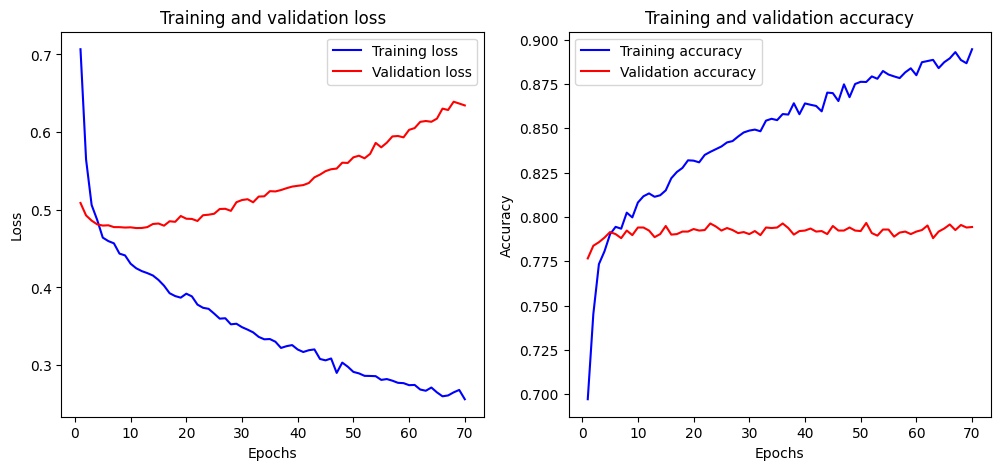

In [158]:
def plot_history(history):
    train_loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    train_acc_values = history.history['accuracy']
    val_acc_values = history.history['val_accuracy']
    epochs = range(1, len(train_loss_values) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_values, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_values, 'b', label='Training loss')
    plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)

#### Overall Accuracy and F1-Score for Task A:

In [159]:
from sklearn.metrics import accuracy_score, f1_score

# Predict classes for the test set
y_pred_prob = model.predict(test_vecs_w2v)

# Convert y_pred to 1D array
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("Overall Accuracy:", overall_accuracy)
print("F1 Score:", f1)

110/110 [==============================] - 0s 1ms/step
Overall Accuracy: 0.7942857142857143
F1 Score: 0.7641520111571437


In [160]:
# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)


              precision    recall  f1-score   support

           0       0.81      0.95      0.88      2659
           1       0.66      0.30      0.41       841

    accuracy                           0.79      3500
   macro avg       0.73      0.63      0.64      3500
weighted avg       0.77      0.79      0.76      3500



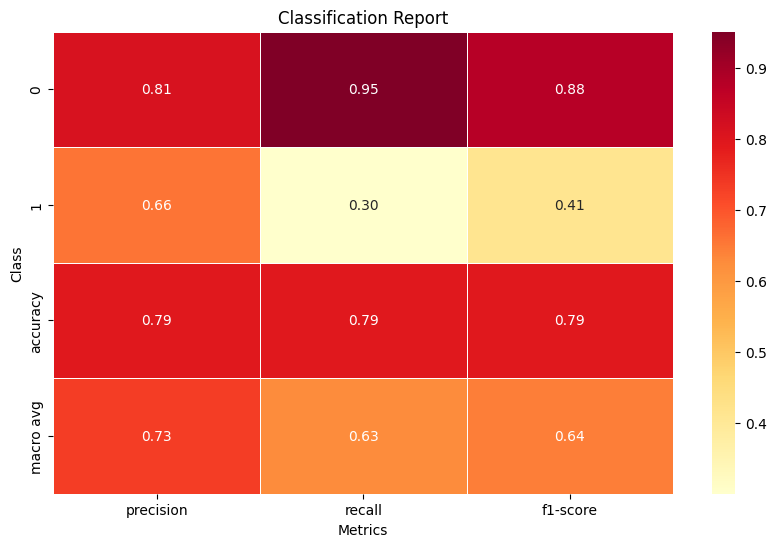

In [161]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Plot the heatmap with a different colormap
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlOrRd", fmt=".2f", linewidths=.5)
# Change "YlOrRd" to the desired colormap name
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.show()


# TASK B

In [162]:
df.head()

,text,label_sexist,label_category,label_vector
0,damn writing pretty chaotic,not sexist,none,none
1,yeah apparently bunch misogynistic virgin one ...,not sexist,none,none
2,fuck woman still mp,not sexist,none,none
3,understand know youre right time know isnt eno...,not sexist,none,none
4,surprized didnt stop rape woman,not sexist,none,none


In [163]:
df[df['label_sexist'] == 'sexist']['label_category'].value_counts()

label_category
2. derogation                               1590
3. animosity                                1165
4. prejudiced discussions                    333
1. threats, plans to harm and incitement     310
Name: count, dtype: int64

In [164]:
df_B = df[df['label_sexist'] == 'sexist'][['text', 'label_category']]
df_B['label_category'].value_counts()

label_category
2. derogation                               1590
3. animosity                                1165
4. prejudiced discussions                    333
1. threats, plans to harm and incitement     310
Name: count, dtype: int64

In [165]:
df_B.shape

(3398, 2)

In [166]:
df_B.head()

,text,label_category
8,inside wallet cash bank card credit card debit...,2. derogation
11,get initial chance attractive woman flock see ...,2. derogation
17,ugly chick pussy pussy,2. derogation
18,fuck nine mm get arab fuck monkey,"1. threats, plans to harm and incitement"
19,talk shit idiot like nazi like bitch,3. animosity


#### ONE HOT ENCODING

In [167]:
y_encoded = pd.get_dummies(df_B['label_category'])
df_B = pd.concat([df_B, y_encoded], axis=1)

In [168]:
y_encoded

,"1. threats, plans to harm and incitement",2. derogation,3. animosity,4. prejudiced discussions
8,False,True,False,False
11,False,True,False,False
17,False,True,False,False
18,True,False,False,False
19,False,False,True,False
...,...,...,...,...
13977,False,True,False,False
13990,False,False,True,False
13993,False,False,False,True
13994,False,True,False,False


In [169]:
type(y_encoded.values)

numpy.ndarray

In [170]:
df_B.head()

,text,label_category,"1. threats, plans to harm and incitement",2. derogation,3. animosity,4. prejudiced discussions
8,inside wallet cash bank card credit card debit...,2. derogation,False,True,False,False
11,get initial chance attractive woman flock see ...,2. derogation,False,True,False,False
17,ugly chick pussy pussy,2. derogation,False,True,False,False
18,fuck nine mm get arab fuck monkey,"1. threats, plans to harm and incitement",True,False,False,False
19,talk shit idiot like nazi like bitch,3. animosity,False,False,True,False


In [171]:
# Tokenize the 'text' column
df_B['tokenized_text'] = df_B['text'].apply(word_tokenize)
df_B.head()

,text,label_category,"1. threats, plans to harm and incitement",2. derogation,3. animosity,4. prejudiced discussions,tokenized_text
8,inside wallet cash bank card credit card debit...,2. derogation,False,True,False,False,"[inside, wallet, cash, bank, card, credit, car..."
11,get initial chance attractive woman flock see ...,2. derogation,False,True,False,False,"[get, initial, chance, attractive, woman, floc..."
17,ugly chick pussy pussy,2. derogation,False,True,False,False,"[ugly, chick, pussy, pussy]"
18,fuck nine mm get arab fuck monkey,"1. threats, plans to harm and incitement",True,False,False,False,"[fuck, nine, mm, get, arab, fuck, monkey]"
19,talk shit idiot like nazi like bitch,3. animosity,False,False,True,False,"[talk, shit, idiot, like, nazi, like, bitch]"


In [172]:
df_B.shape

(3398, 7)

#### WORD2VEC

In [173]:
#WORD2VEC()
cores = multiprocessing.cpu_count() # Count the number of cores in a computer, important for a parameter of the model
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     vector_size=300,
                     sample=6e-5,
                     alpha=0.03,
                     min_alpha=0.0007,
                     negative=20,
                     workers=cores-1)

#BUILD_VOCAB()
t = time()
w2v_model.build_vocab(df_B["tokenized_text"], progress_per=1000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

#TRAIN()
w2v_model.train(df_B["tokenized_text"], total_examples=w2v_model.corpus_count, epochs=1000, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))


Time to build vocab: 0.0 mins
Time to train the model: 0.57 mins


#### DATA SPLIT

In [174]:
#First defining the X (input), and the y (output)
y = y_encoded.values
X = np.array(df_B["tokenized_text"])

#And here is the train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2)

In [175]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2548,), (850,), (2548, 4), (850, 4))

#### VECTORIZATION USING TFIDF

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with custom analyzer
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)

# Fit and transform the data to obtain the TF-IDF matrix
matrix = vectorizer.fit_transform(X_train)

# Get the feature names from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Calculate IDF values manually
idf_values = vectorizer.idf_

# Create a dictionary mapping feature names to IDF values
tfidf = dict(zip(feature_names, idf_values))

print('Vocabulary size:', len(tfidf))


Vocabulary size: 583


In [177]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += w2v_model.wv[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [178]:
train_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_train)])
train_vecs_w2v = scale(train_vecs_w2v)

test_vecs_w2v = np.concatenate([buildWordVector(z, 300) for z in map(lambda x: x, X_test)])
test_vecs_w2v = scale(test_vecs_w2v)

print ('shape for train set : ',train_vecs_w2v.shape,
      '\nshape for test set : ', test_vecs_w2v.shape)

shape for train set :  (2548, 300) 
shape for test set :  (850, 300)


In [179]:
train_vecs_w2v, test_vecs_w2v, y_train,  y_test

(array([[ 0.0980645 , -1.13527311, -0.86138367, ...,  0.14372941,
          0.27813563, -0.8067019 ],
        [ 0.97383296,  0.57385707, -0.14899142, ...,  0.85369977,
         -1.44376789, -0.16538189],
        [-0.4236806 , -0.18620248, -0.24586396, ...,  0.27094904,
          0.05946927,  0.22744321],
        ...,
        [-0.1451201 ,  1.04833308, -1.29671693, ...,  1.19654021,
         -1.11078349, -0.06668145],
        [-0.63114498,  1.12709839,  1.08558311, ..., -0.70654339,
          0.41924439, -0.36355443],
        [-0.79933972,  1.77650413, -1.30193522, ..., -1.13056355,
          2.28078136,  0.79300135]]),
 array([[ 1.02295577, -0.91668084, -1.33686044, ...,  0.12852796,
         -0.549676  , -0.10012402],
        [-0.29469601,  0.15825482,  0.61440595, ...,  0.04466804,
          0.66427802,  0.21571484],
        [ 0.09595811, -0.06127939,  1.42455019, ..., -0.33670029,
          0.79565012, -0.91871263],
        ...,
        [ 1.12836041, -0.75184122,  0.1172032 , ...,  

#### BUILDING THE NEURAL MODEL

In [180]:
model = Sequential()

model.add(Dense(128, activation='relu', input_dim=300))
model.add(Dropout(0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               38528     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                                 
Total params: 39044 (152.52 KB)
Trainable params: 39044 (152.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### MODEL TRAINING

In [181]:
history = model.fit(train_vecs_w2v, y_train, epochs=70, batch_size=70,
                   validation_data=(test_vecs_w2v,y_test))
loss, accuracy = model.evaluate(train_vecs_w2v, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_vecs_w2v, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Epoch 1/70
37/37 [==============================] - 1s 8ms/step - loss: 2.0740 - accuracy: 0.3218 - val_loss: 1.2481 - val_accuracy: 0.4400
Epoch 2/70
37/37 [==============================] - 0s 3ms/step - loss: 1.5974 - accuracy: 0.4180 - val_loss: 1.2071 - val_accuracy: 0.4506
Epoch 3/70
37/37 [==============================] - 0s 4ms/step - loss: 1.4125 - accuracy: 0.4505 - val_loss: 1.1898 - val_accuracy: 0.4435
Epoch 4/70
37/37 [==============================] - 0s 4ms/step - loss: 1.3357 - accuracy: 0.4580 - val_loss: 1.1757 - val_accuracy: 0.4506
Epoch 5/70
37/37 [==============================] - 0s 3ms/step - loss: 1.1930 - accuracy: 0.4925 - val_loss: 1.1776 - val_accuracy: 0.4482
Epoch 6/70
37/37 [==============================] - 0s 3ms/step - loss: 1.1756 - accuracy: 0.4776 - val_loss: 1.1674 - val_accuracy: 0.4541
Epoch 7/70
37/37 [==============================] - 0s 4ms/step - loss: 1.0996 - accuracy: 0.5196 - val_loss: 1.1629 - val_accuracy: 0.4647
Epoch 8/70
37/37 [==

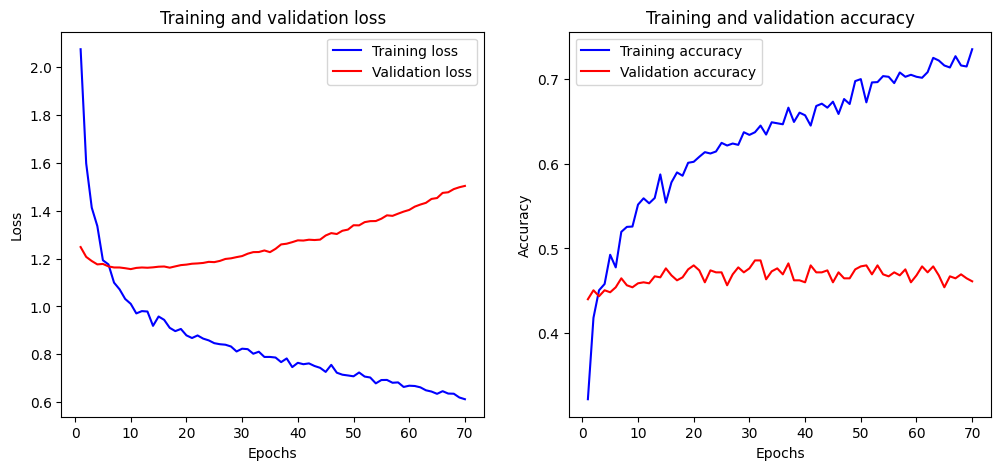

In [182]:
def plot_history(history):
    train_loss_values = history.history['loss']
    val_loss_values = history.history['val_loss']
    train_acc_values = history.history['accuracy']
    val_acc_values = history.history['val_accuracy']
    epochs = range(1, len(train_loss_values) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_values, 'blue', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'red', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_values, 'blue', label='Training loss')
    plt.plot(epochs, val_loss_values, 'red', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(history)


#### Overall Accuracy and F1-Score for Task B

In [183]:
from sklearn.metrics import accuracy_score, f1_score

# Predict classes for the test set
y_pred_prob = model.predict(test_vecs_w2v)

# Convert y_pred to 1D array
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("Overall Accuracy:", overall_accuracy)
print("F1 Score:", f1)


27/27 [==============================] - 0s 2ms/step
Overall Accuracy: 0.40588235294117647
F1 Score: 0.41441110717526675


In [184]:
# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.59      0.16      0.25        80
           1       0.48      0.57      0.52       391
           2       0.42      0.32      0.36       302
           3       0.44      0.16      0.23        77

   micro avg       0.46      0.41      0.43       850
   macro avg       0.48      0.30      0.34       850
weighted avg       0.47      0.41      0.41       850
 samples avg       0.41      0.41      0.41       850



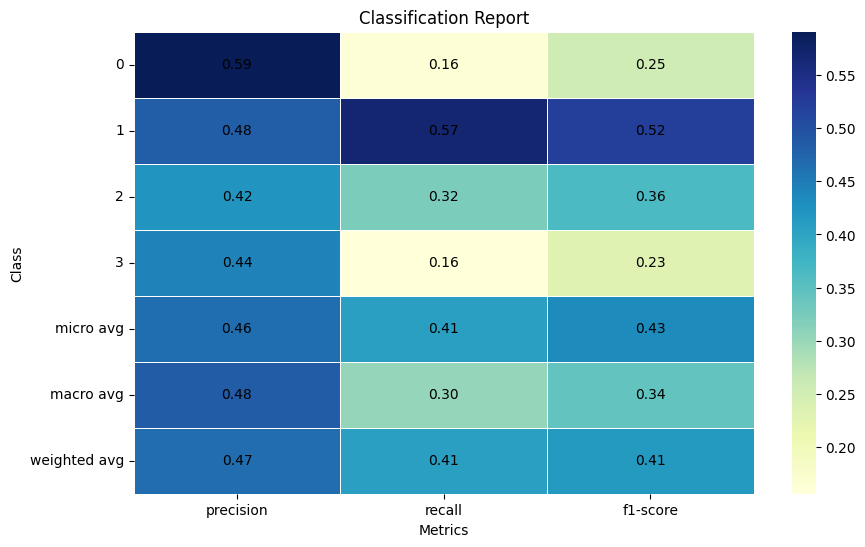

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Plot the heatmap with customized annotation color
plt.figure(figsize=(10, 6))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5,
            annot_kws={"color": "black"})
plt.title('Classification Report')
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.show()
